<center>
<img src='https://sharif.edu/~izadi/images/logo_sharif.png' alt="SUT logo" width=260 height=300 class="saturate">
</center>

<font face="Times New Roman">
    <div dir=ltr align=center>
        <font color=0F5298 size=7>
            Machine Learning Course Project
        </font>
        <br><br>
        <font color=2565AE size=5>
            Computer Engineering Department<br>Lecturer: Dr. Sharifi-Zarchi<br>Spring 2025
        </font>
        <br><br>
        <font color=3C99D size=5>
            Project 8: MVTec AD Anomaly Detection
        </font>
        <br><br>
        <font color=6EACDA size=4>
            Author: Amir Mohammad Fakhimi
        </font>
    </div>
    <br><br>
</font>

This notebook is a **course project template** for **MVTec AD anomaly detection**.

You will:

1. Run a **PaDiM baseline** (feature-statistics anomaly detection).
2. Implement **your own method** (student method) using **only `train/good`** for training.
3. Report **quantitative metrics** (per-category + overall) and **qualitative visualizations**.
4. Compare **PaDiM vs your method** on the *same* categories and test images.

> This notebook is intentionally "report-first": after each model runs, you call a small set of functions to get tables and plots.

## 0) Setup

### What you need
- Python + PyTorch + torchvision
- Common scientific stack (NumPy / pandas / matplotlib / scikit-learn)
- MVTec AD dataset extracted under `DATASET_ROOT`

### What you will get
- Per-category results (tables + bar plots)
- Overall results (macro mean across categories + micro over all test images)
- Qualitative overlays (input, anomaly map, overlay + GT contour)

In [1]:
import math
import random
import time
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms
from torchvision.models import resnet18, resnet34, ResNet18_Weights, ResNet34_Weights

from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve

from IPython.display import display

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = 'mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

NUM_WORKERS = 0
PIN_MEMORY = (DEVICE == 'cuda')

print('DEVICE:', DEVICE)

DEVICE: cuda


## 1) Download the dataset (MVTec AD)

This project uses the **MVTec Anomaly Detection (MVTec AD)** dataset.

1. Download the **whole dataset** (~4.9 GB) from the official downloads page:
   - https://www.mvtec.com/company/research/datasets/mvtec-ad/downloads

2. Extract it so you end up with a folder named `mvtec_anomaly_detection/` that contains the category folders:
   - `bottle/`, `cable/`, `capsule/`, ..., `zipper/`

Example (Linux/macOS):

```bash
# Put the downloaded archive in the same folder as this notebook
tar -xf mvtec_anomaly_detection.tar.xz
```

If you prefer a direct download link, the official site links to a `mydrive.ch` file under "Download the whole dataset".

In [3]:
DATASET_ROOT = Path('./mvtec_anomaly_detection')
DATASET_ROOT.mkdir(parents=True, exist_ok=True)

In [4]:
print('DATA_ROOT:', DATASET_ROOT.resolve())
print('Exists?', DATASET_ROOT.exists())

DATA_ROOT: M:\uni\ml\project\mvtec_anomaly_detection
Exists? True


## 2) Dataset utilities

This section provides small helper functions to:
- list `.png` images in a directory
- collect MVTec paths for one category:
  - `train_good`
  - `test_good`
  - `test_anomaly`
  - a mapping from **test-relative key** → **GT mask path**

In [5]:
def list_images(directory_path: Path) -> List[Path]:
    """Return a sorted list of `.png` files inside `directory_path`."""
    if not directory_path.exists():
        return []

    return sorted([p for p in directory_path.iterdir() if p.is_file() and p.suffix.lower() == '.png' and not p.name.startswith('._')])


def mvtec_collect_category(category_directory: Path) -> Dict[str, object]:
    """Collect MVTec paths for one category.

    Returns a dict with:
      - train_good: List[Path]
      - test_good: List[Path]
      - test_anomaly: List[Path]
      - gt_masks_by_name: Dict[str, Path]

    The `gt_masks_by_name` key format is:
      '<defect_type>/<file_name>.png'  (relative to `test/`)

    This avoids filename collisions across defect types (e.g., `scratch/000.png` vs `contamination/000.png`).
    """
    train_good = list_images(category_directory / 'train' / 'good')

    test_good = list_images(category_directory / 'test' / 'good')
    test_anomaly: List[Path] = []
    gt_masks_by_name: Dict[str, Path] = {}

    test_directory = category_directory / 'test'
    gt_directory = category_directory / 'ground_truth'

    if test_directory.exists():
        for defect in sorted([p for p in test_directory.iterdir() if p.is_dir() and p.name != 'good']):
            test_anomaly.extend(list_images(defect))

    if gt_directory.exists():
        for defect in sorted([p for p in gt_directory.iterdir() if p.is_dir()]):
            for mask_path in list_images(defect):
                key = f"{defect.name}/{mask_path.name.replace('_mask', '')}"
                gt_masks_by_name[key] = mask_path

    return {
        'train_good': train_good,
        'test_good': test_good,
        'test_anomaly': sorted(test_anomaly),
        'gt_masks_by_name': gt_masks_by_name,
    }

## 3) Dataset + DataLoaders (6 points)

We wrap MVTec paths into a `Dataset` that returns:

- `image` (tensor, resized to 224×224)
- `label` (0 = good, 1 = anomaly)
- `mask` (binary tensor) if GT exists, otherwise `None`
- `image_path` (string)

We also define a collate function so the batch keeps `image_path` and `mask` fields.

In [6]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [7]:
padim_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [8]:
class MVTecDataset(Dataset):
    """A minimal dataset wrapper for MVTec AD.

    Each item returns a dict:
      - image: FloatTensor (3, 224, 224)
      - label: LongTensor scalar (0=good, 1=anomaly)
      - mask: FloatTensor (1, 224, 224) with {0,1} values, or None (for good images)
      - image_path: str
    """

    def __init__(
        self,
        image_paths: List[Path],
        labels: List[int],
        mask_paths: Optional[List[Optional[Path]]] = None,
        transform=None,
    ):
        """Create a dataset.

        Args:
            image_paths: Paths to images.
            labels: 0 for good, 1 for anomaly (aligned with `image_paths`).
            mask_paths: Optional list of GT mask paths (aligned with `image_paths`).
            transform: torchvision transform applied to the PIL image.
        """
        assert len(image_paths) == len(labels), 'image_paths and labels must have the same length'
        if mask_paths is not None:
            assert len(mask_paths) == len(image_paths), 'mask_paths must align with image_paths'

        self.image_paths = image_paths
        self.labels = labels
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self) -> int:
        """Number of items in the dataset."""
        return len(self.image_paths)

    def __getitem__(self, index: int) -> Dict[str, object]:
        """Load one image (and optional mask) and return a dict."""
        image_path = self.image_paths[index]
        label = self.labels[index]
        mask_path = self.mask_paths[index] if self.mask_paths is not None else None

        image = Image.open(image_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        mask = None
        # Keep masks aligned with the resized image (224×224).
        if mask_path is not None:
            mask = Image.open(mask_path).convert('L')
            mask = transforms.Resize((224, 224))(mask)
            mask = transforms.ToTensor()(mask)

        return {
            'image': image,
            'label': torch.tensor(label, dtype=torch.long),
            'mask': mask,
            'image_path': str(image_path),
        }

In [9]:
def mvtec_collate_fn(batch: List[Dict[str, object]]) -> Dict[str, object]:
    """Collate function that keeps image paths and (optional) masks in the batch."""
    images = torch.stack([b['image'] for b in batch], dim=0)
    labels = torch.stack([b['label'] for b in batch], dim=0)
    paths = [b['image_path'] for b in batch]
    masks = [b['mask'] for b in batch]

    return {'image': images, 'label': labels, 'image_path': paths, 'mask': masks}

## 4) Dataset sanity checks (stats + visuals)

Before running models, we:
- check basic dataset counts per category
- pick **fixed samples** (good + anomaly with GT available)
- visualize those samples so qualitative results are consistent across runs

In [10]:
def get_categories(data_root: Path) -> List[str]:
    """Return category folder names under `data_root` (e.g., 'bottle', 'cable', ...)."""
    if not data_root.exists():
        return []

    return sorted([p.name for p in data_root.iterdir() if p.is_dir() and not p.name.startswith('.')])

In [11]:
CATEGORIES = get_categories(DATASET_ROOT)

print('Num categories:', len(CATEGORIES))
print('First 15:', CATEGORIES[:15])

Num categories: 15
First 15: ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


In [12]:
def select_fixed_samples_by_category(
    dataset_root: Path,
    categories: List[str],
    seed: int = 0,
    n_good: int = 1,
    n_anom: int = 1,
) -> Dict[str, List[str]]:
    """Select fixed sample image paths per category for qualitative visualization.

    We pick:
      - `n_good` images from `test/good`
      - `n_anom` images from anomaly folders in `test/` **only if a GT mask exists**

    Returns:
        Dict[category -> List[path_str]] (good samples first, then anomalies).
    """
    rng = np.random.RandomState(seed)
    out: Dict[str, List[str]] = {}

    for category in categories:
        data = mvtec_collect_category(dataset_root / category)
        good_paths: List[Path] = [p for p in data['test_good'] if not p.name.startswith('._')]
        anomaly_paths: List[Path] = [p for p in data['test_anomaly'] if not p.name.startswith('._')]
        gt_by_name: Dict[str, Path] = dict(data['gt_masks_by_name'])

        # Keep only anomalies that have GT masks (so contours/metrics are meaningful).
        anomaly_paths = [
            p for p in anomaly_paths
            if str(p.relative_to(dataset_root / category / 'test')).replace('\\', '/') in gt_by_name
        ]

        sel: List[str] = []

        if n_good > 0 and len(good_paths) > 0:
            g_idx = rng.choice(len(good_paths), size=min(n_good, len(good_paths)), replace=False)
            sel.extend([str(good_paths[j]) for j in g_idx])

        if n_anom > 0 and len(anomaly_paths) > 0:
            a_idx = rng.choice(len(anomaly_paths), size=min(n_anom, len(anomaly_paths)), replace=False)
            sel.extend([str(anomaly_paths[j]) for j in a_idx])

        out[category] = sel

    return out

In [13]:
QUAL_SAMPLE_PATHS_BY_CAT = select_fixed_samples_by_category(
    DATASET_ROOT, CATEGORIES, seed=SEED, n_good=1, n_anom=1
)

print('Example qualitative samples (first 3 categories):')
for c in CATEGORIES[:3]:
    print(' -', c, '->', [Path(p).name for p in QUAL_SAMPLE_PATHS_BY_CAT[c]])

Example qualitative samples (first 3 categories):
 - bottle -> ['000.png', '004.png']
 - cable -> ['045.png', '002.png']
 - capsule -> ['011.png', '018.png']


In [14]:
def category_stats(category: str) -> Dict[str, object]:
    """Compute a few quick dataset statistics for one MVTec category."""
    category_data = mvtec_collect_category(DATASET_ROOT / category)
    defect_types = sorted({Path(p).parent.name for p in category_data['test_anomaly']})

    return {
        'category': category,
        'train_good': len(category_data['train_good']),
        'test_good': len(category_data['test_good']),
        'test_anomaly': len(category_data['test_anomaly']),
        'num_defect_types': len(defect_types),
        'defect_types': ', '.join(defect_types),
    }

In [15]:
if len(CATEGORIES):
    df_stats = pd.DataFrame([category_stats(c) for c in CATEGORIES])
    display(df_stats)
else:
    print('No categories found. Check DATA_ROOT.')

category  train_good  test_good  test_anomaly  num_defect_types  \
0       bottle         209         20            63                 3   
1        cable         224         58            92                 8   
2      capsule         219         23           109                 5   
3       carpet         280         28            89                 5   
4         grid         264         21            57                 5   
5     hazelnut         391         40            70                 4   
6      leather         245         32            92                 5   
7    metal_nut         220         22            93                 4   
8         pill         267         26           141                 7   
9        screw         320         41           119                 5   
10        tile         230         33            84                 5   
11  toothbrush          60         12            30                 1   
12  transistor         213         60            40                 4   
13        wood         247         19            60                 5   
14      zipper         240         32           119                 7   

                                         defect_types  
0           broken_large, broken_small, contamination  
1   bent_wire, cable_swap, combined, cut_inner_ins...  
2       crack, faulty_imprint, poke, scratch, squeeze  
3       color, cut, hole, metal_contamination, thread  
4     bent, broken, glue, metal_contamination, thread  
5                             crack, cut, hole, print  
6                        color, cut, fold, glue, poke  
7                          bent, color, flip, scratch  
8   color, combined, contamination, crack, faulty_...  
9   manipulated_front, scratch_head, scratch_neck,...  
10         crack, glue_strip, gray_stroke, oil, rough  
11                                          defective  
12       bent_lead, cut_lead, damaged_case, misplaced  
13             color, combined, hole, liquid, scratch  
14  broken_teeth, combined, fabric_border, fabric_...

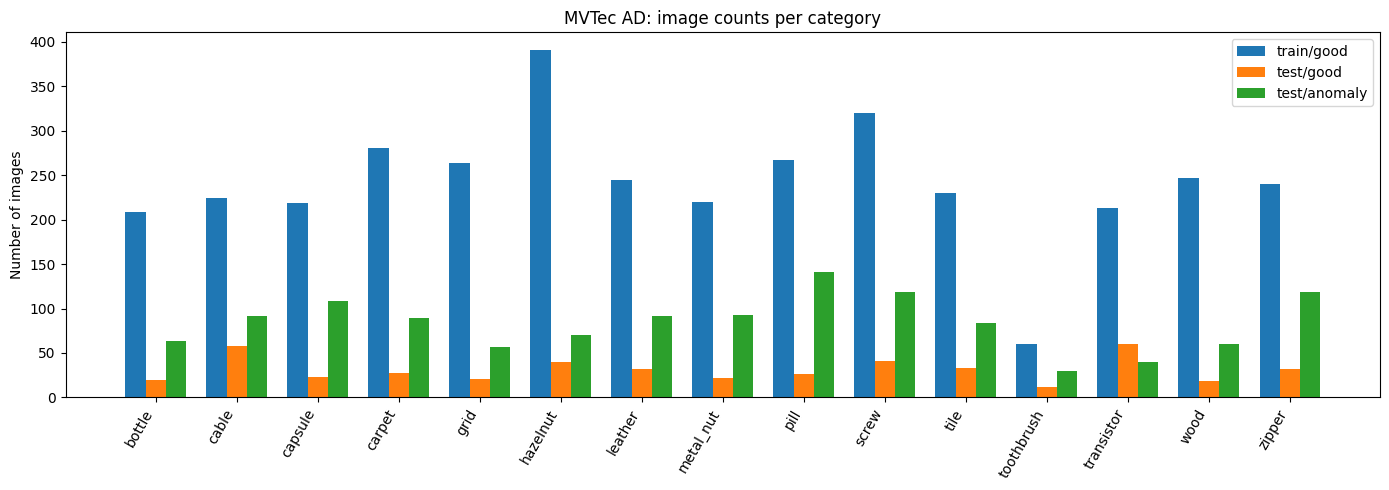

In [16]:
if 'df_stats' in globals() and len(df_stats):
    x = np.arange(len(df_stats))
    width = 0.25
    plt.figure(figsize=(14, 5))

    plt.bar(x - width, df_stats['train_good'].values, width=width, label='train/good')
    plt.bar(x, df_stats['test_good'].values, width=width, label='test/good')
    plt.bar(x + width, df_stats['test_anomaly'].values, width=width, label='test/anomaly')

    plt.xticks(x, df_stats['category'].values, rotation=60, ha='right')
    plt.ylabel('Number of images')

    plt.title('MVTec AD: image counts per category')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [17]:
def show_fixed_samples(category: str) -> None:
    """Show the fixed qualitative samples (good + anomaly) picked for a category."""
    # Skip macOS AppleDouble metadata files (._*) — they are not real images.
    sample_paths = [p for p in QUAL_SAMPLE_PATHS_BY_CAT.get(category, []) if not Path(p).name.startswith('._')]
    if not sample_paths:
        print('No fixed samples for', category, '(QUAL_SAMPLE_PATHS_BY_CAT empty).')
        return

    samples = []
    for p in sample_paths:
        p = str(p)
        tag = 'good' if Path(p).parent.name == 'good' else 'anomaly'
        samples.append((tag, p))

    cols = min(4, len(samples))
    rows = int(math.ceil(len(samples) / cols))

    plt.figure(figsize=(12, 3.5 * rows))
    for i, (tag, p) in enumerate(samples, 1):
        img = Image.open(p).convert('RGB')
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'{category} | {tag}')

    plt.tight_layout()
    plt.show()

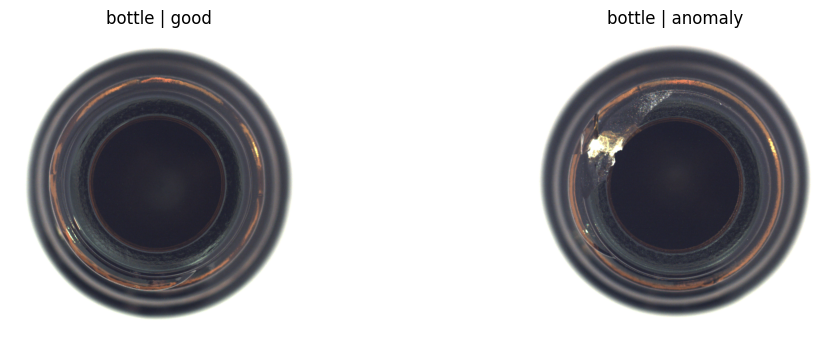

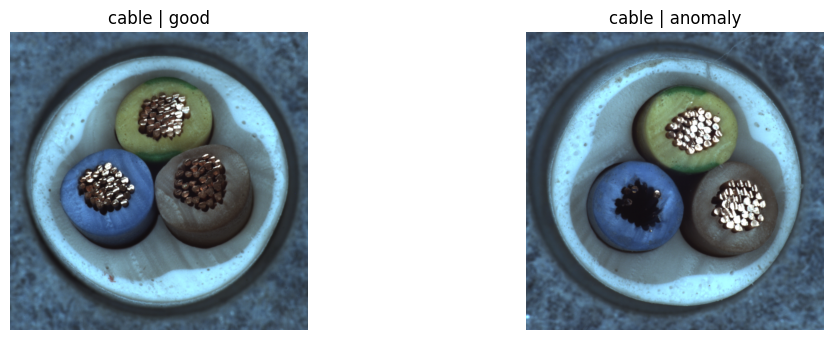

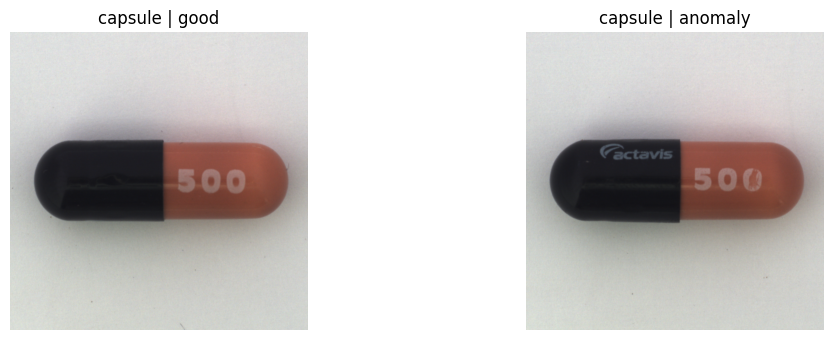

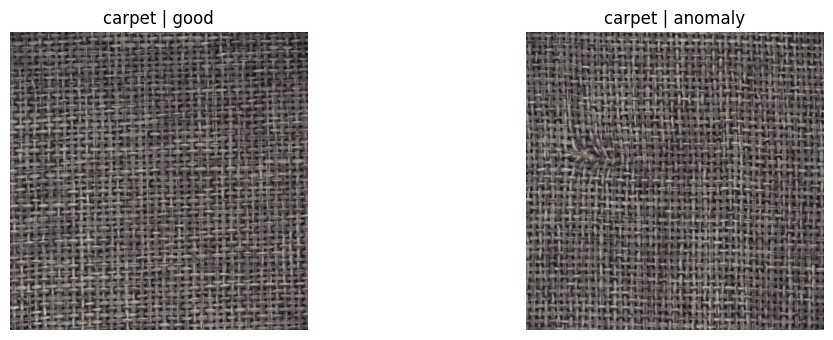

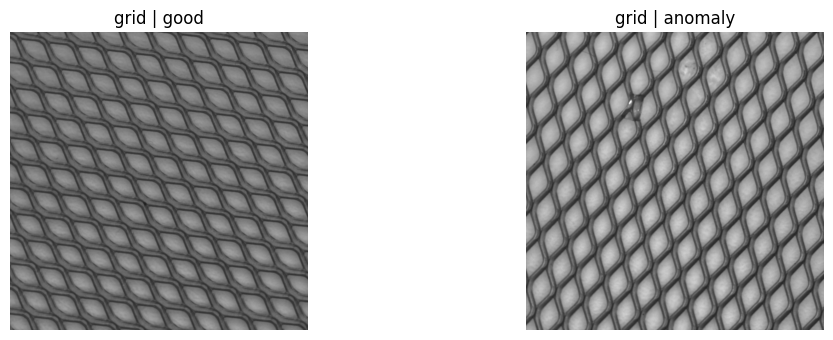

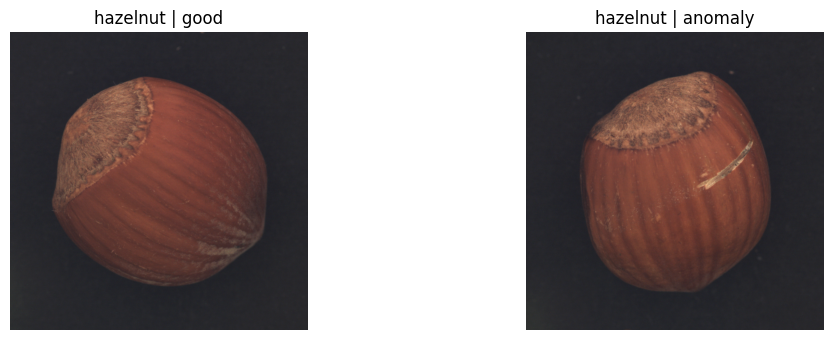

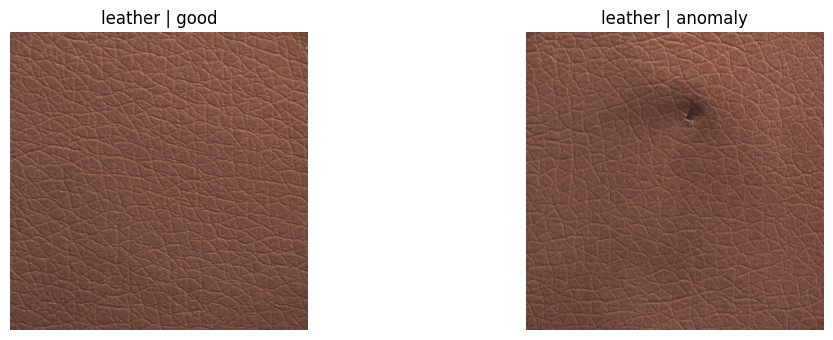

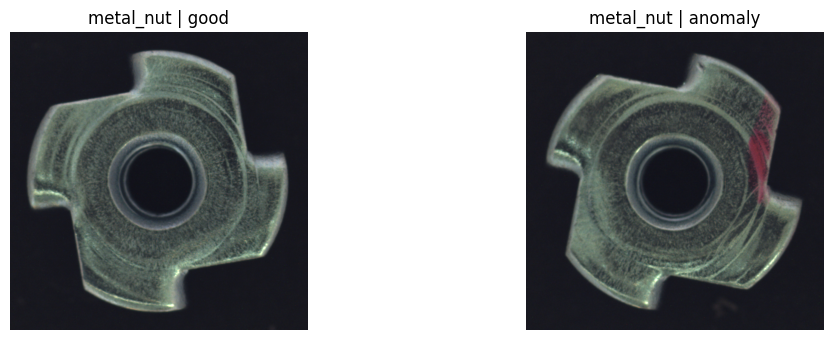

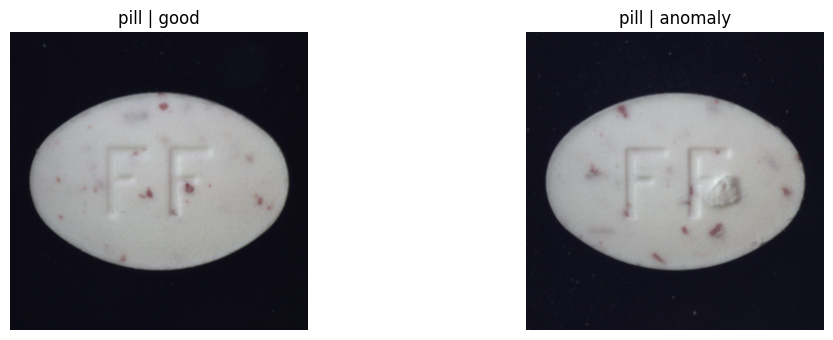

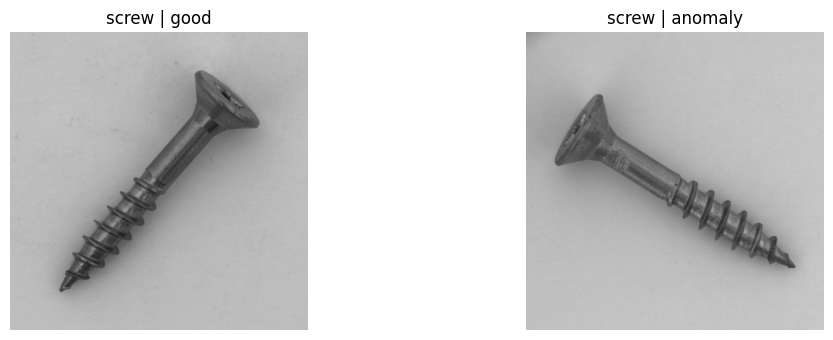

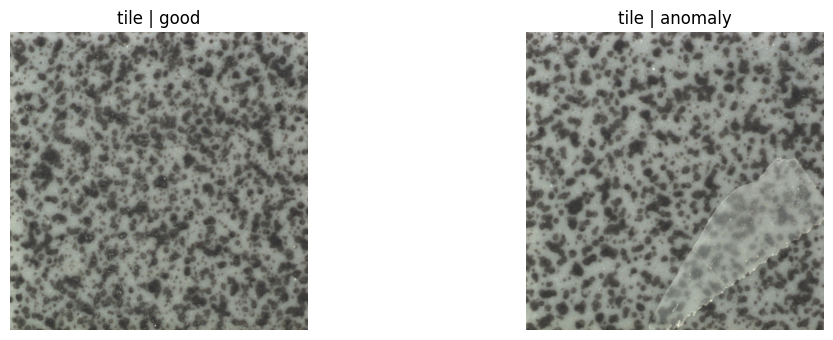

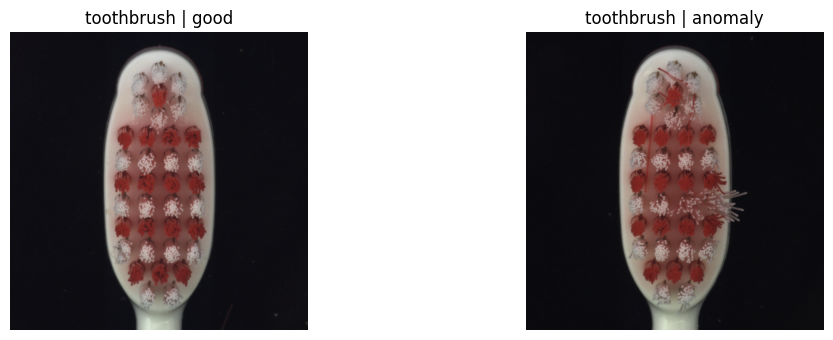

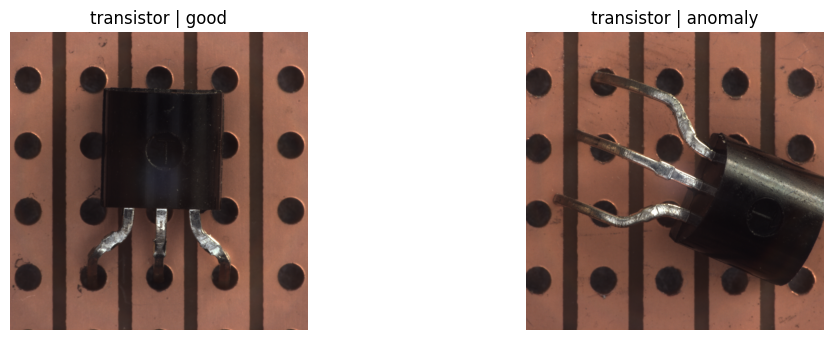

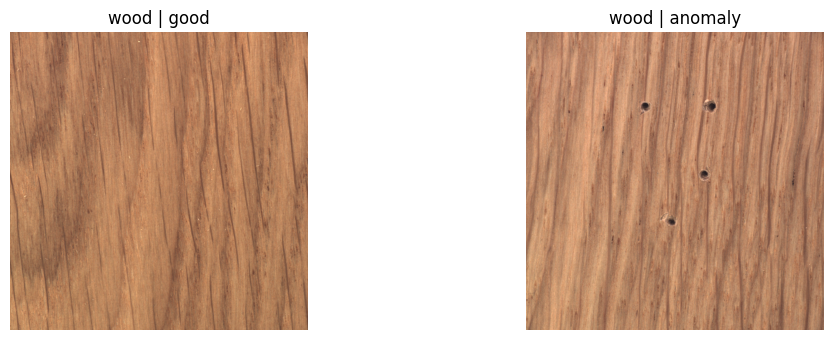

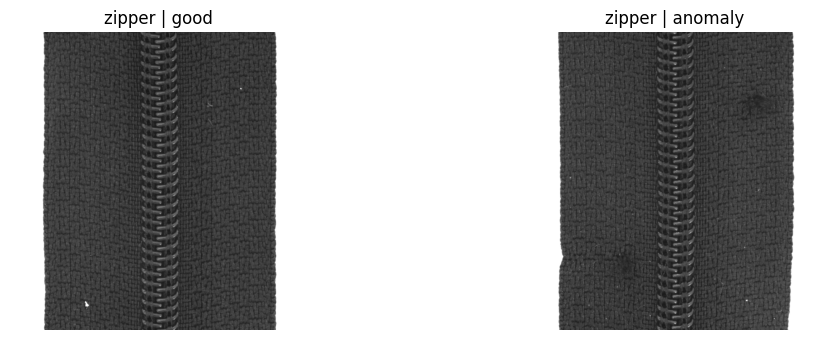

In [18]:
if len(CATEGORIES):
    for category in CATEGORIES:
        show_fixed_samples(category)

## 5) PaDiM baseline implementation (30 points)

PaDiM (Patch Distribution Modeling) builds a **Gaussian model** over deep features extracted from a pretrained backbone.

High-level steps per category:
1. Extract intermediate backbone features on `train/good`
2. Build per-location feature distribution (mean + covariance)
3. Score each test image by **Mahalanobis distance** to the learned distribution
4. Produce:
   - pixel-level anomaly map
   - image-level score (aggregation of top anomaly pixels)

In [19]:
class ResNetFeatureExtractor(nn.Module):
    """Extract intermediate feature maps from a pretrained ResNet backbone.

    Args:
        backbone: 'resnet18' or 'resnet34'
        pretrained: whether to load ImageNet weights
        layers: which layer feature maps to return (e.g., ('layer1','layer2','layer3'))
    """

    def __init__(
        self,
        backbone: str = 'resnet18',
        pretrained: bool = True,
        layers: Tuple[str, ...] = ('layer1', 'layer2', 'layer3'),
    ):
        """Initialize the backbone and register which layers to return."""
        super().__init__()

        weights_18 = ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        weights_34 = ResNet34_Weights.IMAGENET1K_V1 if pretrained else None
        if backbone == 'resnet18':
            self.backbone = resnet18(weights=weights_18)
        elif backbone == 'resnet34':
            self.backbone = resnet34(weights=weights_34)
        else:
            raise ValueError('Unsupported backbone: ' + backbone)

        self.layers = layers
    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:
        """Return a list of feature maps, ordered as `self.layers`."""
        features = {}
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        for name, layer in self.backbone.named_children():
            if name in self.layers:
                x = layer(x)
                features[name] = x
        return [features[k] for k in self.layers]

In [20]:
def align_and_concat_features(
    feature_list: List[torch.Tensor],
    target_hw: Tuple[int, int] = (28, 28),
) -> torch.Tensor:
    """Resize feature maps to `target_hw` and concatenate them along channel dimension.

    This produces a single embedding tensor of shape (B, C_total, H, W).
    """
    aligned = []
    for f in feature_list:
        if f.shape[-2:] != target_hw:
            f = F.interpolate(f, size=target_hw, mode='bilinear', align_corners=False)
        aligned.append(f)
    return torch.cat(aligned, dim=1)

In [21]:
def build_channel_indices(total_channels: int, d: int, seed: int = 0) -> np.ndarray:
    """Select `d` channels out of `total_channels` (deterministic given `seed`)."""
    rng = np.random.RandomState(seed)
    if d >= total_channels:
        return np.arange(total_channels)
    index = rng.choice(total_channels, size=d, replace=False)

    return np.sort(index)

In [22]:
def extract_embeddings(
    feature_model: nn.Module,
    loader: DataLoader,
    channel_index: Optional[np.ndarray],
    target_hw: Tuple[int, int],
    device: str,
) -> Tuple[torch.Tensor, List[str], List[int], List[object]]:
    """Extract aligned embeddings for all images in a loader.

    Returns:
        embeddings: Tensor (N, C, H, W) on CPU
        paths: list of image path strings
        labels: list of int labels (0/1)
        masks: list of masks (tensor or None), aligned with paths
    """
    feature_model.eval()

    embeddings = []
    all_paths = []
    all_labels = []
    all_masks = []

    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device)
            output = feature_model(images)
            aligned = align_and_concat_features(output, target_hw=target_hw)
            if channel_index is not None:
                aligned = aligned[:, channel_index, :, :]
            embeddings.append(aligned.cpu().numpy())
            all_paths.extend(batch['image_path'])
            all_labels.extend(batch['label'].tolist())
            all_masks.extend(batch['mask'])

    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings, all_paths, all_labels, all_masks

In [23]:
def fit_padim_gaussian(train_embeddings: torch.Tensor, cov_eps: float = 1e-3) -> Tuple[torch.Tensor, torch.Tensor]:
    """Fit per-location Gaussian parameters for PaDiM.

    Args:
        train_embeddings: Tensor (N, C, H, W) from train/good images.
        cov_eps: Small diagonal jitter for numerical stability.

    Returns:
        mu_map: Tensor (C, H, W) mean feature at each location.
        cov_inv: Tensor (H*W, C, C) inverse covariance per location.
    """
    N, C, H, W = train_embeddings.shape
    train_embeddings = train_embeddings.permute(0, 2, 3, 1).reshape(-1, C)  # (N*H*W, C)
    mu_map = train_embeddings.mean(dim=0).reshape(C, H, W)
    cov = torch.zeros((H*W, C, C), device=train_embeddings.device)
    for i in range(H*W):
        cov[i] = torch.cov(train_embeddings[:, i, :].T) + cov_eps * torch.eye(C, device=train_embeddings.device)
    cov_inv = torch.linalg.inv(cov)
    return mu_map, cov_inv

In [24]:
def padim_score_maps(test_embeddings: torch.Tensor, mu_map: torch.Tensor, cov_inv: torch.Tensor) -> torch.Tensor:
    """Compute PaDiM anomaly score maps (Mahalanobis distance) for test embeddings.

    Returns:
        score_maps: Tensor (N, H, W) where higher values indicate more anomalous pixels.
    """
    N, C, H, W = test_embeddings.shape
    test_embeddings = test_embeddings.permute(0, 2, 3, 1).reshape(-1, C)  # (N*H*W, C)
    mu_map = mu_map.permute(1, 2, 0).reshape(-1, C)  # (H*W, C)
    diff = test_embeddings - mu_map  # (N*H*W, C)
    scores = torch.zeros(diff.shape[0], device=test_embeddings.device)
    for i in range(diff.shape[0]):
        scores[i] = torch.sqrt(diff[i].unsqueeze(0) @ cov_inv[i % (H*W)] @ diff[i].unsqueeze(1)).squeeze()
    return scores.reshape(N, H, W)

In [25]:
def normalize_01(x: np.ndarray) -> np.ndarray:
    """Normalize an array to [0, 1] (safe for constant arrays)."""
    x = x.astype(np.float32)
    mn, mx = float(x.min()), float(x.max())
    if mx - mn < 1e-12:
        return np.zeros_like(x)
    return (x - mn) / (mx - mn)


def aggregate_image_score(score_map: np.ndarray, aggregation: str = 'mean_topk', topk_frac: float = 0.1) -> float:
    """Aggregate a pixel anomaly map into a single image-level score."""
    s = score_map.reshape(-1)

    if aggregation == 'max':
        return float(s.max())
    if aggregation == 'mean':
        return float(s.mean())
    if aggregation == 'mean_topk':
        k = max(1, int(topk_frac * len(s)))
        return float(np.mean(np.partition(s, -k)[-k:]))

    raise ValueError('Unknown aggregation: ' + aggregation)

In [26]:
@dataclass
class PadimConfig:
    """Configuration for running PaDiM on a single MVTec category."""

    category: str
    backbone: str = 'resnet18'
    pretrained: bool = True
    layers: Tuple[str, ...] = ('layer1', 'layer2', 'layer3')
    target_hw: Tuple[int, int] = (28, 28)

    # Random channel subsampling (PaDiM uses a subset of channels for efficiency)
    d: int = 100

    # Gaussian fitting stability
    covariance_epsilon: float = 1e-3

    # Optional post-processing on anomaly maps
    smooth_sigma: Optional[float] = 2.0  # set None to disable smoothing

    # Image score aggregation
    image_aggregation: str = 'mean_topk'
    topk_fraction: float = 0.1

    # DataLoader settings
    batch_size: int = 32


def gaussian_smooth_np(m: np.ndarray, sigma: float) -> np.ndarray:
    """Apply a simple separable Gaussian blur to a 2D numpy array."""
    radius = int(3 * sigma)
    if radius <= 0:
        return m.astype(np.float32)

    xs = np.arange(-radius, radius + 1)
    k = np.exp(-(xs ** 2) / (2 * sigma ** 2))
    k = (k / k.sum()).astype(np.float32)

    # Convolve over height
    tmp = np.pad(m, ((radius, radius), (0, 0)), mode='reflect')
    out = np.zeros_like(m, dtype=np.float32)
    for i in range(m.shape[0]):
        out[i] = (tmp[i:i + 2 * radius + 1] * k[:, None]).sum(axis=0)

    # Convolve over width
    tmp2 = np.pad(out, ((0, 0), (radius, radius)), mode='reflect')
    out2 = np.zeros_like(out, dtype=np.float32)
    for j in range(out.shape[1]):
        out2[:, j] = (tmp2[:, j:j + 2 * radius + 1] * k[None, :]).sum(axis=1)

    return out2

In [27]:
import typing
if typing.TYPE_CHECKING:
    def image_metrics(y_true: np.ndarray, y_score: np.ndarray) -> Dict[str, float]: ...
    def compute_pixel_auc(gt_mask: np.ndarray, score_map: np.ndarray) -> float: ...
    def compute_best_dice(gt_mask: np.ndarray, score_map: np.ndarray) -> float: ...

def run_padim_category(config: PadimConfig) -> Dict[str, object]:
    """Run PaDiM on one category and return a result dict used by the reporting code."""
    t0 = time.time()

    d = mvtec_collect_category(DATASET_ROOT / config.category)
    train_paths = d['train_good']
    test_paths = d['test_good'] + d['test_anomaly']
    test_labels = [0] * len(d['test_good']) + [1] * len(d['test_anomaly'])

    mask_paths = []
    for p, y in zip(test_paths, test_labels):
        if y == 0:
            mask_paths.append(None)
        else:
            rel_key = str(Path(p).relative_to(DATASET_ROOT / config.category / 'test')).replace('\\', '/')
            mask_paths.append(d['gt_masks_by_name'].get(rel_key, None))

    train_dataset = MVTecDataset(train_paths, labels=[0] * len(train_paths), mask_paths=None, transform=padim_transform)
    test_dataset = MVTecDataset(test_paths, labels=test_labels, mask_paths=mask_paths, transform=padim_transform)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=False, num_workers=NUM_WORKERS,
                              pin_memory=PIN_MEMORY, collate_fn=mvtec_collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=NUM_WORKERS,
                             pin_memory=PIN_MEMORY, collate_fn=mvtec_collate_fn)

    feature_model = ResNetFeatureExtractor(backbone=config.backbone, pretrained=config.pretrained, layers=config.layers).to(DEVICE)

    channel_index = build_channel_indices(total_channels=512, d=config.d, seed=SEED)
    train_embeddings, _, _, _ = extract_embeddings(feature_model, train_loader, channel_index, config.target_hw, DEVICE)
    mu_map, cov_inv = fit_padim_gaussian(torch.from_numpy(train_embeddings), cov_eps=config.covariance_epsilon)
    test_embeddings, paths, labels_out, masks_out = extract_embeddings(feature_model, test_loader, channel_index, config.target_hw, DEVICE)
    score_maps = []
    for i in range(test_embeddings.shape[0]):
        score_map = padim_score_maps(test_embeddings[i:i+1], mu_map, cov_inv)[0].cpu().numpy()
        if config.smooth_sigma is not None:
            score_map = gaussian_smooth_np(score_map, sigma=config.smooth_sigma)
        score_maps.append(score_map)
    
    

    scores = [aggregate_image_score(score_maps[i], aggregation=config.image_aggregation, topk_frac=config.topk_fraction)
              for i in
              range(len(score_maps))]
    scores = normalize_01(np.array(scores))

    img_m = image_metrics(labels_out, scores.tolist())

    pixel_aucs = []
    best_dices = []
    for i in range(len(labels_out)):
        if labels_out[i] == 1 and masks_out[i] is not None:
            gt = masks_out[i].numpy().squeeze(0)
            pixel_aucs.append(compute_pixel_auc(gt, score_maps[i]))
            best_dices.append(compute_best_dice(gt, normalize_01(score_maps[i])))

    pix_auc = float(np.nanmean(pixel_aucs)) if len(pixel_aucs) else float('nan')
    dice = float(np.nanmean(best_dices)) if len(best_dices) else float('nan')

    out = {
        'category': config.category,
        'image_metrics': img_m,
        'pixel_auroc': pix_auc,
        'pixel_best_dice': dice,
        'paths': paths,
        'labels': labels_out,
        'scores': scores.tolist(),
        'score_maps': score_maps,
        'masks': masks_out,
        'runtime_sec': float(time.time() - t0),
        'config': config,
    }
    return out

## 6) Student implementation (60 points)

Implement your own anomaly detection method with the same interface:

- `fit(train_loader)` uses **only `train/good`**
- `predict(test_loader)` must return:
  - `paths`: list of test paths in the same order as the loader
  - `scores`: anomaly scores (higher = more anomalous)
  - `score_maps`: pixel anomaly maps aligned with `paths` (required for pixel metrics + qualitative overlays)

In [28]:
# Student method: k-NN patch-based anomaly detection.
# Reuses ResNetFeatureExtractor and align_and_concat_features from section 5 (PaDiM).
# We do not call the incomplete extract_embeddings; we use the same backbone + alignment in a local loop.


from sklearn.neighbors import NearestNeighbors


def _extract_embeddings_knn(
    feature_model: nn.Module,
    loader: DataLoader,
    channel_index: np.ndarray,
    target_hw: Tuple[int, int],
    device: str,
) -> Tuple[torch.Tensor, List[str], List[int], List[object]]:
    """Extract aligned, channel-subsampled embeddings using section-5 ResNet + align_and_concat.
    Batch format from loader is dict: 'image', 'image_path', 'label', 'mask'.
    Returns: (embeddings (N, C, H, W), paths, labels, masks)."""
    feature_model.eval()
    emb_list: List[torch.Tensor] = []
    paths_list: List[str] = []
    labels_list: List[int] = []
    masks_list: List[object] = []

    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device)
            out_maps = feature_model(images)
            aligned = align_and_concat_features(out_maps, target_hw=target_hw)
            aligned = aligned[:, channel_index, :, :]
            emb_list.append(aligned.cpu())
            paths_list.extend(batch['image_path'])
            labels_list.extend(batch['label'].tolist())
            masks_list.extend(batch['mask'])

    embeddings = torch.cat(emb_list, dim=0)
    return embeddings, paths_list, labels_list, masks_list


class StudentMethod:
    """k-NN patch-based anomaly detector. Uses only train/good; same ResNet backbone as PaDiM."""

    def __init__(
        self,
        k: int = 9,
        backbone: str = 'resnet18',
        pretrained: bool = True,
        layers: Tuple[str, ...] = ('layer1', 'layer2', 'layer3'),
        target_hw: Tuple[int, int] = (28, 28),
        d: int = 100,
        seed: int = 42,
        image_aggregation: str = 'mean_topk',
        topk_fraction: float = 0.1,
        max_memory_patches: Optional[int] = 50000,
    ):
        self.k = k
        self.backbone = backbone
        self.pretrained = pretrained
        self.layers = layers
        self.target_hw = target_hw
        self.d = d
        self.seed = seed
        self.image_aggregation = image_aggregation
        self.topk_fraction = topk_fraction
        self.max_memory_patches = max_memory_patches
        self._feature_model = None
        self._channel_index = None
        self._nn_model = None
        self._H = None
        self._W = None

    def fit(self, train_loader: DataLoader) -> None:
        """Build memory bank of normal patch features and fit k-NN (only train/good)."""
        device = DEVICE
        feature_model = ResNetFeatureExtractor(
            backbone=self.backbone, pretrained=self.pretrained, layers=self.layers
        ).to(device)
        with torch.no_grad():
            for batch in train_loader:
                x = batch['image'].to(device)
                out = feature_model(x)
                aligned = align_and_concat_features(out, target_hw=self.target_hw)
                total_c = aligned.shape[1]
                break
        channel_index = build_channel_indices(total_channels=total_c, d=self.d, seed=self.seed)
        train_emb, _, _, _ = _extract_embeddings_knn(
            feature_model, train_loader, channel_index, self.target_hw, device
        )
        N, C, H, W = train_emb.shape
        self._H, self._W = H, W
        patches = train_emb.permute(0, 2, 3, 1).reshape(-1, C).numpy().astype(np.float32)
        if self.max_memory_patches is not None and patches.shape[0] > self.max_memory_patches:
            rng = np.random.RandomState(self.seed)
            idx = rng.choice(patches.shape[0], size=self.max_memory_patches, replace=False)
            patches = patches[idx]
        self._feature_model = feature_model
        self._channel_index = channel_index
        self._nn_model = NearestNeighbors(n_neighbors=self.k, algorithm='auto', metric='euclidean')
        self._nn_model.fit(patches)

    def predict(self, test_loader: DataLoader) -> Dict[str, object]:
        """Return paths, scores, score_maps, runtime_sec (same order as loader)."""
        t0 = time.time()
        device = DEVICE
        if self._feature_model is None or self._nn_model is None:
            raise RuntimeError('Call fit() before predict().')
        test_emb, paths, _, _ = _extract_embeddings_knn(
            self._feature_model, test_loader, self._channel_index, self.target_hw, device
        )
        N, C, H, W = test_emb.shape
        score_maps_list = []
        for i in range(N):
            patches_i = test_emb[i].permute(1, 2, 0).reshape(-1, C).numpy().astype(np.float32)
            dists, _ = self._nn_model.kneighbors(patches_i, n_neighbors=self.k, return_distance=True)
            patch_scores = np.mean(dists, axis=1)
            score_map = patch_scores.reshape(H, W).astype(np.float32)
            score_maps_list.append(score_map)
        score_maps = np.stack(score_maps_list, axis=0)
        scores = np.array([
            aggregate_image_score(score_maps[i], aggregation=self.image_aggregation, topk_frac=self.topk_fraction)
            for i in range(N)
        ], dtype=np.float32)
        scores = normalize_01(scores)
        return {
            'paths': paths,
            'scores': scores.tolist(),
            'score_maps': score_maps,
            'runtime_sec': float(time.time() - t0),
        }


In [29]:
# Run k-NN student method per category (same data setup as PaDiM).

def run_student_category(category: str, student: StudentMethod) -> Dict[str, object]:
    """Build train/test loaders for one category, fit student on train, predict on test."""
    d = mvtec_collect_category(DATASET_ROOT / category)
    train_paths = d['train_good']
    test_paths = d['test_good'] + d['test_anomaly']
    test_labels = [0] * len(d['test_good']) + [1] * len(d['test_anomaly'])
    mask_paths = []
    for p, y in zip(test_paths, test_labels):
        if y == 0:
            mask_paths.append(None)
        else:
            rel_key = str(Path(p).relative_to(DATASET_ROOT / category / 'test')).replace('\\', '/')
            mask_paths.append(d['gt_masks_by_name'].get(rel_key, None))
    train_ds = MVTecDataset(train_paths, labels=[0] * len(train_paths), mask_paths=None, transform=padim_transform)
    test_ds = MVTecDataset(test_paths, labels=test_labels, mask_paths=mask_paths, transform=padim_transform)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, collate_fn=mvtec_collate_fn)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, collate_fn=mvtec_collate_fn)
    student.fit(train_loader)
    return student.predict(test_loader)

student_out_by_cat = {}
for cat in CATEGORIES:
    student = StudentMethod(k=9, backbone='resnet18', target_hw=(28, 28), d=100, seed=SEED)
    student_out_by_cat[cat] = run_student_category(cat, student)
    print(cat, 'done.')


bottle done.
cable done.
capsule done.
carpet done.
grid done.
hazelnut done.
leather done.
metal_nut done.
pill done.
screw done.
tile done.
toothbrush done.
transistor done.
wood done.
zipper done.


## 7) Metrics + Reporting utilities (10 points)

### Image-level metrics
- AUROC
- Average Precision (AP)
- Best F1 (threshold swept on PR curve)
- Balanced Accuracy (at best-F1 threshold)

### Pixel-level metrics
All methods (PaDiM and Student) must provide `score_maps`, so we also compute:
- Pixel AUROC
- Best Dice (threshold swept)

### Reporting
We summarize a model output into:
- per-category table
- overall table (macro mean + micro pooled)

Plotting helpers take those tables and draw charts (bars + simple comparisons).

In [30]:
def compute_best_f1(y_true: np.ndarray, y_score: np.ndarray) -> Tuple[float, float]:
    """Compute the best F1 score by sweeping the PR-curve thresholds.

    Returns:
        (best_f1, best_threshold)
    """
    y_true = np.asarray(y_true).ravel()
    y_score = np.asarray(y_score).ravel().astype(np.float64)
    if len(y_true) == 0 or len(y_score) == 0 or len(y_true) != len(y_score):
        return (float('nan'), float('nan'))
    if np.all(y_true == 0) or np.all(y_true == 1):
        return (float('nan'), float('nan'))
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    f1 = np.zeros_like(thresholds)
    for i in range(len(thresholds)):
        denom = precision[i] + recall[i]
        f1[i] = (2.0 * precision[i] * recall[i] / denom) if denom > 0 else 0.0
    best_idx = np.nanargmax(f1) if np.any(np.isfinite(f1)) else 0
    best_f1 = float(f1[best_idx]) if np.isfinite(f1[best_idx]) else float('nan')
    best_thr = float(thresholds[best_idx]) if best_idx < len(thresholds) else float('nan')
    return (best_f1, best_thr)


def balanced_accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Balanced accuracy = (TPR + TNR) / 2."""
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    if len(y_true) == 0 or len(y_pred) == 0 or len(y_true) != len(y_pred):
        return float('nan')
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    return float((tpr + tnr) / 2.0)



def image_metrics(y_true: np.ndarray, y_score: np.ndarray) -> Dict[str, float]:
    """Compute image-level anomaly detection metrics from labels and anomaly scores.

    This function evaluates a model that outputs *one anomaly score per image*.
    Higher scores are assumed to indicate "more anomalous".

    Args:
        y_true:
            Array-like of shape (N,). Binary ground-truth labels per image.
            Convention in this notebook: 0 = normal/good, 1 = anomalous/defective.
        y_score:
            Array-like of shape (N,). Real-valued anomaly scores per image.
            Larger values should correspond to higher anomaly likelihood.

    Returns:
        A dictionary with the following keys (float values):
            - 'auroc':
                Area Under the ROC Curve computed from (y_true, y_score). Measures
                ranking quality across all thresholds. Undefined if only one class
                is present in y_true.
            - 'ap':
                Average Precision (area under the precision-recall curve).
                Particularly informative under class imbalance. Undefined if only
                one class is present.
            - 'best_f1':
                Maximum F1 score achieved by thresholding y_score. The threshold
                is selected by `compute_best_f1` (typically scanning over candidate
                thresholds derived from scores).
            - 'best_thr':
                The score threshold that achieves 'best_f1'. Prediction rule:
                `y_pred = (y_score >= best_thr)`.
            - 'bal_acc':
                Balanced accuracy at `best_thr`, i.e. average of TPR and TNR.
                Useful when the dataset is imbalanced.

    Notes:
        - If N == 0, or inputs are empty, all metrics return NaN.
        - If y_true contains only one class (all 0s or all 1s), AUROC and AP are
          mathematically undefined; this function returns NaN for all metrics to
          avoid misleading values.
        - The chosen 'best_thr' is *computed on the evaluated split*. In a strict
          experimental setup you would choose thresholds on a validation set, then
          report test metrics using that fixed threshold.
    """
    y_true = np.asarray(y_true).ravel()
    y_score = np.asarray(y_score).ravel().astype(np.float64)
    nan_dict = {'auroc': float('nan'), 'ap': float('nan'), 'best_f1': float('nan'), 'best_thr': float('nan'), 'bal_acc': float('nan')}
    if len(y_true) == 0 or len(y_score) == 0 or len(y_true) != len(y_score):
        return nan_dict
    if np.all(y_true == 0) or np.all(y_true == 1):
        return nan_dict
    auroc = float(roc_auc_score(y_true, y_score))
    ap = float(average_precision_score(y_true, y_score))
    best_f1, best_thr = compute_best_f1(y_true, y_score)
    y_pred = (y_score >= best_thr).astype(np.int64) if np.isfinite(best_thr) else np.zeros_like(y_true)
    bal_acc = balanced_accuracy(y_true, y_pred)
    return {'auroc': auroc, 'ap': ap, 'best_f1': best_f1, 'best_thr': best_thr, 'bal_acc': bal_acc}


def compute_pixel_auc(gt_mask: np.ndarray, score_map: np.ndarray) -> float:
    """Compute pixel-level AUROC for a *single image* using a GT mask and a score map.

    This evaluates segmentation-style anomaly detection, where the model outputs an
    anomaly score for each pixel. Higher scores are assumed to indicate higher
    anomaly likelihood.

    Args:
        gt_mask:
            Binary ground-truth mask of shape (H, W). Values are interpreted as:
            0 = normal pixel, 1 = anomalous/defect pixel.
        score_map:
            Per-pixel anomaly scores. Typically shape (H, W), but can differ if the
            model outputs a lower-resolution map. In that case, this function will
            upsample the score map to (H, W) using bilinear interpolation.

    Returns:
        Pixel AUROC as a float. Returns NaN if the ground-truth mask contains only
        one class (all zeros or all ones), because AUROC is undefined in that case.

    Behavior:
        - If `gt_mask.shape != score_map.shape`, `score_map` is resized to
          `gt_mask.shape` via torch + bilinear interpolation (align_corners=False).
        - The metric is computed by flattening both arrays to 1D vectors and
          calling `roc_auc_score(y_true, y_score)`.
    """
    gt_mask = np.asarray(gt_mask).squeeze()
    score_map = np.asarray(score_map).astype(np.float32)
    if gt_mask.ndim != 2:
        return float('nan')
    score_map = np.squeeze(score_map)
    if score_map.ndim != 2 or gt_mask.shape != score_map.shape:
        t = torch.from_numpy(score_map).float().unsqueeze(0).unsqueeze(0)
        t = F.interpolate(t, size=tuple(gt_mask.shape), mode='bilinear', align_corners=False)
        score_map = t.squeeze().numpy()
    gt_flat = gt_mask.ravel().astype(np.int64)
    score_flat = score_map.ravel().astype(np.float64)
    if np.all(gt_flat == 0) or np.all(gt_flat == 1):
        return float('nan')
    return float(roc_auc_score(gt_flat, score_flat))


def compute_best_dice(gt_mask: np.ndarray, score_map: np.ndarray) -> float:
    """Compute the best Dice score over a fixed threshold grid for a single image.

    This is a fast approximation of the "best possible" Dice you can get by choosing
    a threshold to binarize a score map into a predicted anomaly mask.

    Args:
        gt_mask:
            Binary ground-truth mask of shape (H, W). Values are interpreted as:
            0 = normal pixel, 1 = anomalous/defect pixel.
        score_map:
            Per-pixel anomaly scores. Expected shape (H, W), but if different,
            the function upsamples `score_map` to (H, W) with bilinear interpolation.

    Returns:
        The maximum Dice coefficient achieved across thresholds in
        `np.linspace(0.0, 1.0, 51)`.

    Definition:
        For a threshold t, predicted mask is `pred = (score_map >= t)`.
        Dice(pred, gt) = 2 * |pred ∩ gt| / (|pred| + |gt|).
        If both pred and gt are empty (denominator == 0), Dice is defined as 1.0.
    """
    gt_mask = np.asarray(gt_mask).squeeze()
    score_map = np.asarray(score_map).astype(np.float32)
    if gt_mask.ndim != 2:
        return float('nan')
    score_map = np.squeeze(score_map)
    if score_map.ndim != 2 or gt_mask.shape != score_map.shape:
        t = torch.from_numpy(score_map).float().unsqueeze(0).unsqueeze(0)
        t = F.interpolate(t, size=tuple(gt_mask.shape), mode='bilinear', align_corners=False)
        score_map = t.squeeze().numpy()
    gt_bin = (gt_mask > 0).astype(np.float32)
    best_dice = 0.0
    for t in np.linspace(0.0, 1.0, 51):
        pred = (score_map >= t).astype(np.float32)
        inter = np.sum(pred * gt_bin)
        denom = np.sum(pred) + np.sum(gt_bin)
        dice = (2.0 * inter / denom) if denom > 0 else 1.0
        best_dice = max(best_dice, float(dice))
    return best_dice

In [31]:
import typing as _typing
if _typing.TYPE_CHECKING:
    def _mask_to_numpy(mask_obj) -> _typing.Optional[np.ndarray]: ...

def visualize_examples(
    model_out: Dict[str, object],
    *,
    gt_out: Optional[Dict[str, object]] = None,
    sample_paths: Optional[List[str]] = None,
    n: int = 6,
    seed: int = 0,
    vis_size: Tuple[int, int] = (224, 224),
    title_prefix: str = '',
) -> None:
    """Visualize anomaly maps and optional GT contours for selected images.

    Works for both PaDiM and the student method.

    Per row:
      1) Input image
      2) Upsampled anomaly map (normalized to [0, 1])
      3) Overlay (image + anomaly map) with GT contour (if available)

    Notes
    -----
    - `model_out` must contain `paths` and `score_maps`.
    - If `gt_out` is provided, `labels/masks` are taken from it; otherwise from `model_out`.
    """
    H, W = vis_size

    if 'paths' not in model_out:
        raise ValueError('model_out is missing required key "paths".')
    if 'score_maps' not in model_out:
        raise ValueError('model_out is missing required key "score_maps".')

    model_paths: List[str] = [str(p) for p in model_out['paths']]
    maps = np.asarray(model_out['score_maps'], dtype=np.float32)
    if maps.ndim != 3:
        raise ValueError(f'score_maps must have shape (N, H, W); got {maps.shape}.')
    if len(model_paths) != maps.shape[0]:
        raise ValueError(f'paths length ({len(model_paths)}) != score_maps N ({maps.shape[0]}).')

    # For student outputs, we want labels/masks from GT (PaDiM outputs / dataset).
    ref = gt_out if gt_out is not None else model_out
    ref_paths: List[str] = [str(p) for p in ref.get('paths', model_paths)]
    labels: List[int] = list(ref.get('labels', [0] * len(ref_paths)))
    masks = ref.get('masks', None)

    model_path_to_idx = {p: i for i, p in enumerate(model_paths)}
    ref_path_to_idx = {p: i for i, p in enumerate(ref_paths)}

    # Choose which paths to display.
    if sample_paths is not None and len(sample_paths):
        chosen = [str(p) for p in sample_paths]
    else:
        rng = np.random.RandomState(seed)
        chosen = rng.choice(ref_paths, size=min(n, len(ref_paths)), replace=False).tolist()
    chosen = chosen[:min(n, len(chosen))]

    plt.figure(figsize=(12, 4 * len(chosen)))

    for r, p in enumerate(chosen):
        if p not in model_path_to_idx:
            # If this happens, student output paths do not match dataset paths.
            continue
        mi = model_path_to_idx[p]

        image = Image.open(p).convert('RGB').resize((W, H))

        amap_up = F.interpolate(
            torch.tensor(maps[mi])[None, None].float(),
            size=(H, W),
            mode='bilinear',
            align_corners=False,
        ).squeeze().cpu().numpy()
        amap_up = normalize_01(amap_up)

        # GT contour if available
        gt = None
        y = 0
        if p in ref_path_to_idx:
            ri = ref_path_to_idx[p]
            y = int(labels[ri]) if ri < len(labels) else 0
            if y == 1 and masks is not None and ri < len(masks) and masks[ri] is not None:
                gt = _mask_to_numpy(masks[ri])
                if gt is not None and gt.shape != (H, W):
                    gt = np.array(
                        Image.fromarray((gt > 0.5).astype(np.uint8) * 255).resize((W, H), resample=Image.NEAREST)
                    )
                    gt = (gt > 127).astype(np.uint8)

        # 1) Input
        plt.subplot(len(chosen), 3, 3 * r + 1)
        plt.imshow(image)
        plt.axis('off')
        prefix = f'{title_prefix} | ' if title_prefix else ''
        plt.title(f'{prefix}Input | y={y}')

        # 2) Map
        plt.subplot(len(chosen), 3, 3 * r + 2)
        plt.imshow(amap_up)
        plt.axis('off')
        plt.title('Anomaly map (upsampled)')

        # 3) Overlay
        plt.subplot(len(chosen), 3, 3 * r + 3)
        plt.imshow(image)
        plt.imshow(amap_up, alpha=0.5)
        if gt is not None:
            plt.contour(gt, levels=[0.5])
        plt.axis('off')
        plt.title('Overlay (GT contour if available)')

    plt.tight_layout()
    plt.show()

In [32]:
@dataclass
class ModelReport:
    """Summary tables + a small qualitative category shortlist for a model."""

    name: str
    df_cat: pd.DataFrame
    df_summary: pd.DataFrame
    qual_categories: List[str]


def _safe_float(x) -> float:
    """Convert to float, returning NaN for None."""
    if x is None:
        return float('nan')
    return float(x)


def _get_count_labels(labels: List[int]) -> Dict[str, int]:
    """Count good/anomaly labels in a list of 0/1 labels."""
    labels = list(labels)
    n = len(labels)
    n_anom = int(np.sum(np.array(labels) == 1))
    n_good = n - n_anom
    return {'n_test_total': n, 'n_test_good': n_good, 'n_test_anom': n_anom}


def _mask_to_numpy(mask_obj) -> Optional[np.ndarray]:
    """Convert a stored mask (torch tensor or numpy array) to a 2D uint8 array."""
    if mask_obj is None:
        return None
    if hasattr(mask_obj, 'numpy'):
        mask_obj = mask_obj.numpy()
    m = np.asarray(mask_obj)
    m = np.squeeze(m)
    return m.astype(np.uint8)

In [33]:
def summarize_outputs(
    out_by_category: Dict[str, Dict[str, object]],
    name: str,
    *,
    gt_labels_by_category: Optional[Dict[str, List[int]]] = None,
    gt_masks_by_category: Optional[Dict[str, Optional[List[np.ndarray]]]] = None,
    use_precomputed_image_metrics: bool = False,
    use_precomputed_pixel_metrics: bool = False,
    enforce_test_size_match: bool = False,
) -> ModelReport:
    """Unify PaDiM + Student summarization.

    Parameters
    ----------
    out_by_category:
        Per-category outputs, each containing: 'paths', 'scores', 'score_maps', 'runtime_sec'.
    name:
        Display name for the report.
    gt_labels_by_category:
        Optional ground-truth image-level labels per category.
        - If None, labels will be read from out_by_category[cat].get('labels', []).
        - For student outputs, you typically pass labels from the PaDiM run.
    gt_masks_by_category:
        Optional ground-truth pixel masks per category (list of HxW uint8/bool arrays, or None).
        Used only when pixel metrics are *computed* (not precomputed).
    use_precomputed_image_metrics:
        If True, reads out.get('image_metrics', {}) for AUROC/AP/F1/etc.
        Otherwise computes image metrics from gt labels + out['scores'].
    use_precomputed_pixel_metrics:
        If True, reads out.get('pixel_auroc') and out.get('pixel_best_dice').
        Otherwise, if gt masks are provided, computes pixel metrics from gt masks + out['score_maps'].
    enforce_test_size_match:
        If True, enforces that len(paths)==len(scores)==len(gt_labels) (helpful for student eval).
        If False, only enforces len(paths)==len(scores).

    Returns
    -------
    ModelReport
        Category table + summary table + a shortlist of categories for qualitative plots.
    """
    rows: List[Dict[str, object]] = []
    all_labels: List[int] = []
    all_scores: List[float] = []

    # Decide which categories define the evaluation scope.
    if gt_labels_by_category is not None:
        categories = list(gt_labels_by_category.keys())
    else:
        categories = list(out_by_category.keys())

    for category in categories:
        out = out_by_category.get(category, {}) if isinstance(out_by_category, dict) else {}

        for k in ['paths', 'scores', 'score_maps', 'runtime_sec']:
            if k not in out:
                raise ValueError(f'{name} output for category "{category}" is missing required key "{k}".')

        # Resolve ground-truth labels.
        if gt_labels_by_category is not None:
            y_true = np.array(gt_labels_by_category.get(category, []), dtype=np.int64)
        else:
            y_true = np.array(out.get('labels', []), dtype=np.int64)

        if enforce_test_size_match:
            if len(out['paths']) != len(y_true):
                raise ValueError(
                    f'{name} output for category "{category}": paths length ({len(out["paths"])}) must match '
                    f'test set size ({len(y_true)}).'
                )

        if len(out['paths']) != len(out['scores']):
            raise ValueError(f'{name} output for category "{category}": paths length does not match scores length.')

        y_score = np.asarray(out['scores'], dtype=np.float32)

        if enforce_test_size_match and len(y_score) != len(y_true):
            raise ValueError(
                f'{name} output for category "{category}": scores length ({len(y_score)}) must match labels length ({len(y_true)}).'
            )

        # Image metrics
        if use_precomputed_image_metrics:
            img_m = out.get('image_metrics', {}) or {}
        else:
            img_m = image_metrics(y_true, y_score) if len(y_true) else {}

        # Pixel metrics
        pixel_auc = float('nan')
        pixel_dice = float('nan')

        if use_precomputed_pixel_metrics:
            pixel_auc = _safe_float(out.get('pixel_auroc', np.nan))
            pixel_dice = _safe_float(out.get('pixel_best_dice', np.nan))
        else:
            masks = None
            if gt_masks_by_category is not None:
                masks = gt_masks_by_category.get(category, None)

            # Only compute pixel metrics if we actually have GT masks and score maps
            if masks is not None and len(masks):
                sm = out.get('score_maps', None)
                if sm is not None and len(sm):
                    sm = np.asarray(sm)
                    per_img_auc: List[float] = []
                    per_img_dice: List[float] = []
                    for i in range(min(len(masks), sm.shape[0])):
                        gt = np.asarray(masks[i])
                        if gt.ndim != 2:
                            continue
                        try:
                            per_img_auc.append(compute_pixel_auc(gt, sm[i]))
                            per_img_dice.append(compute_best_dice(gt, normalize_01(sm[i])))
                        except Exception:
                            # Bad shapes / NaNs should not crash summary; they just lose pixel credit.
                            continue

                    if len(per_img_auc) > 0:
                        pixel_auc = float(np.nanmean(per_img_auc))
                    if len(per_img_dice) > 0:
                        pixel_dice = float(np.nanmean(per_img_dice))

        counts = _get_count_labels(y_true.tolist())

        rows.append({
            'category': category,
            **counts,
            'auroc': _safe_float(img_m.get('auroc', np.nan)),
            'ap': _safe_float(img_m.get('ap', np.nan)),
            'best_f1': _safe_float(img_m.get('best_f1', np.nan)),
            'best_thr': _safe_float(img_m.get('best_thr', np.nan)),
            'bal_acc': _safe_float(img_m.get('bal_acc', np.nan)),
            'pixel_auroc': _safe_float(pixel_auc),
            'pixel_best_dice': _safe_float(pixel_dice),
            'runtime_sec': _safe_float(float(out['runtime_sec'])),
        })

        all_labels.extend(y_true.tolist())
        all_scores.extend(y_score.tolist())

    df_cat = pd.DataFrame(rows).sort_values('auroc', ascending=False).reset_index(drop=True)

    overall_micro = (
        image_metrics(np.array(all_labels, dtype=np.int64), np.array(all_scores, dtype=np.float32))
        if len(all_labels) else {}
    )
    macro_cols = ['auroc', 'ap', 'best_f1', 'bal_acc', 'pixel_auroc', 'pixel_best_dice', 'runtime_sec']
    overall_macro = df_cat[macro_cols].mean(numeric_only=True).to_dict() if len(df_cat) else {}

    df_summary = pd.DataFrame([
        {'scope': 'macro_mean_across_categories', **overall_macro},
        {'scope': 'micro_all_test_images', **{
            'auroc': _safe_float(overall_micro.get('auroc', np.nan)),
            'ap': _safe_float(overall_micro.get('ap', np.nan)),
            'best_f1': _safe_float(overall_micro.get('best_f1', np.nan)),
            'bal_acc': _safe_float(overall_micro.get('bal_acc', np.nan)),
            # There is no meaningful 'micro' pixel score without merging all pixels;
            # keep reporting the macro means for pixel metrics.
            'pixel_auroc': _safe_float(overall_macro.get('pixel_auroc', np.nan)),
            'pixel_best_dice': _safe_float(overall_macro.get('pixel_best_dice', np.nan)),
            'runtime_sec': _safe_float(overall_macro.get('runtime_sec', np.nan)),
        }},
    ])

    # Qualitative shortlist: best / mid / worst (or all if <3 cats)
    if len(df_cat) >= 3:
        qual_categories = [
            str(df_cat.iloc[0]['category']),
            str(df_cat.iloc[len(df_cat) // 2]['category']),
            str(df_cat.iloc[-1]['category']),
        ]
    else:
        qual_categories = df_cat['category'].astype(str).tolist()

    return ModelReport(name=name, df_cat=df_cat, df_summary=df_summary, qual_categories=qual_categories)


def summarize_padim_outputs(padim_out_by_category: Dict[str, Dict[str, object]], name: str = 'PaDiM') -> ModelReport:
    """Backwards-compatible wrapper around summarize_outputs()."""
    return summarize_outputs(
        padim_out_by_category,
        name=name,
        gt_labels_by_category=None,  # read from padim outputs
        gt_masks_by_category=None,
        use_precomputed_image_metrics=True,
        use_precomputed_pixel_metrics=True,
        enforce_test_size_match=False,
    )


def summarize_student_outputs(
    student_out_by_cat: Dict[str, Dict[str, object]],
    padim_out_by_category: Dict[str, Dict[str, object]],
    name: str = 'Student',
) -> ModelReport:
    """Backwards-compatible wrapper around summarize_outputs().

    Uses PaDiM's labels/masks as ground truth, and computes metrics from student scores/score_maps.
    """
    gt_labels_by_category = {cat: (pad_out.get('labels', []) or []) for cat, pad_out in padim_out_by_category.items()}
    gt_masks_by_category = {cat: pad_out.get('masks', None) for cat, pad_out in padim_out_by_category.items()}

    return summarize_outputs(
        student_out_by_cat,
        name=name,
        gt_labels_by_category=gt_labels_by_category,
        gt_masks_by_category=gt_masks_by_category,
        use_precomputed_image_metrics=False,
        use_precomputed_pixel_metrics=False,
        enforce_test_size_match=True,
    )

In [34]:
def show_model_tables(report: ModelReport) -> None:
    """Display the per-category and overall summary tables for one model."""
    display(report.df_cat)
    display(report.df_summary)
    print('Qualitative categories (best/middle/worst):', report.qual_categories)


def _plot_barh_metric(df: pd.DataFrame, metric: str, title: str, xlabel: str) -> None:
    """Horizontal bar plot of a single metric across categories."""
    d = df[['category', metric]].copy()
    d[metric] = pd.to_numeric(d[metric], errors='coerce')
    d = d.dropna(subset=[metric])

    if len(d) == 0:
        print(f'[{title}] nothing to plot (all NaN).')
        return

    d = d.sort_values(metric, ascending=True).reset_index(drop=True)

    plt.figure(figsize=(10, max(4, 0.3 * len(d))))
    plt.barh(d['category'], d[metric])
    plt.xlabel(xlabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_model_charts(report: ModelReport, title_prefix: Optional[str] = None) -> None:
    """Draw a small set of standard charts from a `ModelReport`."""
    tp = title_prefix or report.name
    df = report.df_cat

    _plot_barh_metric(df, 'auroc', f'{tp}: Image-level AUROC per category', 'Image AUROC')
    _plot_barh_metric(df, 'ap', f'{tp}: Image-level AP per category', 'Average Precision')
    _plot_barh_metric(df, 'best_f1', f'{tp}: Best F1 per category', 'Best F1')

    _plot_barh_metric(df, 'pixel_auroc', f'{tp}: Pixel-level AUROC per category', 'Pixel AUROC')
    _plot_barh_metric(df, 'runtime_sec', f'{tp}: Runtime per category', 'Runtime (sec)')

## Qualitative visualization utilities

We use **fixed samples** per category (selected once near the top) to keep qualitative comparisons consistent:

Per sample, we show:
1. Input image
2. Anomaly map (upsampled)
3. Overlay + GT contour (if available)


In [35]:
def _match_sample_indices(
    all_paths: List[str],
    sample_paths: List[str],
    *,
    seed: int = 0,
    n: int = 6,
) -> List[int]:
    """Pick indices for qualitative visualization.

    We prefer the fixed `sample_paths` (exact string match against `all_paths`).
    If none match (e.g., paths were saved differently), we fall back to `n` random indices.
    """
    path_to_idx = {p: i for i, p in enumerate(all_paths)}
    idxs = [path_to_idx[str(p)] for p in sample_paths if str(p) in path_to_idx]

    if len(idxs) == 0:
        rng = np.random.RandomState(seed)
        n_eff = min(n, len(all_paths))
        return list(np.sort(rng.choice(len(all_paths), size=n_eff, replace=False)))

    return idxs[:min(n, len(idxs))]

def plot_model_qualitative(
    report: ModelReport,
    out_by_cat: Dict[str, Dict[str, object]],
    sample_paths_by_cat: Dict[str, List[str]],
    mode: str = 'padim',
    gt_out_by_cat: Optional[Dict[str, Dict[str, object]]] = None,
    categories: Optional[List[str]] = None,
    n_per_cat: int = 6,
    seed: int = 0,
) -> None:
    """Qualitative visualization wrapper used after running each model."""
    global CATEGORIES

    for category in CATEGORIES:
        if category not in sample_paths_by_cat:
            continue
        sample_paths = sample_paths_by_cat[category][:n_per_cat]

        print('=' * 80)
        print(f'{report.name} | category: {category}')

        if mode == 'padim':
            visualize_examples(out_by_cat[category], gt_out=None, sample_paths=sample_paths, n=len(sample_paths), seed=seed, title_prefix=report.name)
        elif mode == 'student':
            assert gt_out_by_cat is not None, 'gt_out_by_cat is required for student qualitative.'
            visualize_examples(out_by_cat[category], gt_out=gt_out_by_cat[category], sample_paths=sample_paths, n=len(sample_paths), seed=seed, title_prefix=report.name)
        else:
            raise ValueError('Unknown mode: ' + mode)

## 8) Run models

This section:
- runs PaDiM and student's model per category
- stores results
- calls the reporting functions to show:
  - tables (per-category + overall)
  - plots
  - qualitative examples

In [37]:
assert len(CATEGORIES) > 0, 'No categories found. Set DATA_ROOT / DATASET_ROOT correctly.'

PADIM_DEFAULTS = dict(
    backbone='resnet18',
    pretrained=True,  # set False if your environment cannot download weights
    layers=('layer1', 'layer2', 'layer3'),
    d=100,
    smooth_sigma=2.0,  # set None to disable
    image_aggregation='mean_topk',
    topk_fraction=0.1,
    batch_size=32,
)

padim_out_by_category = {}

for category in CATEGORIES:
    config = PadimConfig(category=category, **PADIM_DEFAULTS)
    out = run_padim_category(config)
    padim_out_by_category[category] = out

AttributeError: 'str' object has no attribute 'to'

In [ ]:
padim_report = summarize_padim_outputs(padim_out_by_category, name='PaDiM')
show_model_tables(padim_report)
plot_model_charts(padim_report)

plot_model_qualitative(
    padim_report,
    padim_out_by_category,
    QUAL_SAMPLE_PATHS_BY_CAT,
    mode='padim',
    categories=padim_report.qual_categories,
    n_per_cat=6,
    seed=SEED,
)

In [ ]:
# If you haven't implemented the student method yet, this notebook can still run end-to-end.
# We create a dummy `student_out_by_cat` that:
# - uses the same `paths` as PaDiM
# - perturbs PaDiM `score_maps`
# - computes `scores` from the perturbed maps
# - sets a plausible `runtime_sec`

def make_dummy_student_out_by_cat(
    padim_out_by_category: Dict[str, Dict[str, object]],
    *,
    seed: int = 0,
    noise: float = 0.15,
) -> Dict[str, Dict[str, object]]:
    rng = np.random.RandomState(seed)
    out: Dict[str, Dict[str, object]] = {}

    for cat, p in padim_out_by_category.items():
        paths = list(p['paths'])
        pmaps = np.asarray(p['score_maps'], dtype=np.float32)

        smaps = pmaps + noise * rng.randn(*pmaps.shape).astype(np.float32)
        smaps = np.stack([normalize_01(m) for m in smaps], axis=0).astype(np.float32)

        scores = np.asarray([aggregate_image_score(m) for m in smaps], dtype=np.float32)
        scores = normalize_01(scores)

        runtime_sec = float(p.get('runtime_sec', 0.0)) * 0.8 + float(rng.rand() * 0.02)

        out[cat] = {
            'paths': paths,
            'scores': scores.tolist(),
            'score_maps': smaps,
            'runtime_sec': runtime_sec,
        }

    return out

In [ ]:
if student_out_by_cat is None:
    student_out_by_cat = make_dummy_student_out_by_cat(padim_out_by_category, seed=0, noise=0.15)
    print('Generated dummy student_out_by_cat (so the notebook can run without a student implementation).')

In [ ]:
# After implementing `StudentMethod`, run it per category and store outputs here:
#   student_out_by_cat[category] = student.predict(test_loader)
#
# The `predict` output must align with the test loader ordering (paths/scores/score_maps).

In [ ]:
student_report = summarize_student_outputs(student_out_by_cat, padim_out_by_category, name='Student')
show_model_tables(student_report)
plot_model_charts(student_report)

# Qualitative: same fixed samples as PaDiM
plot_model_qualitative(
    student_report,
    student_out_by_cat,
    QUAL_SAMPLE_PATHS_BY_CAT,
    mode='student',
    gt_out_by_cat=padim_out_by_category,  # for GT contours/labels
    categories=student_report.qual_categories,
    n_per_cat=6,
    seed=SEED,
)

## 9) PaDiM vs Student comparison (4 points, just running cells, no TODOs)

We compare PaDiM vs the student method:
- per-category metrics (side-by-side + deltas)
- overall micro/macro summary (side-by-side + deltas)
- integrated qualitative comparison on the **same fixed samples**

In [ ]:
COMPARISON_METRICS = [
    'auroc',
    'ap',
    'best_f1',
    'bal_acc',
    'pixel_auroc',
    'pixel_best_dice',
    'runtime_sec',
]


def build_category_comparison_df(
    padim_report: ModelReport,
    student_report: ModelReport,
    metrics: List[str] = COMPARISON_METRICS,
) -> pd.DataFrame:
    """Merge per-category tables and add delta columns (student - padim)."""
    p = padim_report.df_cat.copy()
    s = student_report.df_cat.copy()

    keep_cols = ['category'] + [m for m in metrics if m in p.columns]
    p = p[keep_cols].rename(columns={m: f'padim_{m}' for m in keep_cols if m != 'category'})

    keep_cols_s = ['category'] + [m for m in metrics if m in s.columns]
    s = s[keep_cols_s].rename(columns={m: f'student_{m}' for m in keep_cols_s if m != 'category'})

    df = p.merge(s, on='category', how='inner')

    for m in metrics:
        pm = f'padim_{m}'
        sm = f'student_{m}'
        if pm in df.columns and sm in df.columns:
            df[f'delta_{m}'] = pd.to_numeric(df[sm], errors='coerce') - pd.to_numeric(df[pm], errors='coerce')

    return df.sort_values('delta_auroc', ascending=False) if 'delta_auroc' in df.columns else df


def build_overall_comparison_df(padim_report: ModelReport, student_report: ModelReport) -> pd.DataFrame:
    """Build a 2-row table comparing macro and micro summaries."""
    def _row(df: pd.DataFrame, scope: str) -> pd.Series:
        r = df[df['scope'] == scope].iloc[0]
        return r

    scopes = ['macro_mean_across_categories', 'micro_all_test_images']
    rows = []

    for scope in scopes:
        pr = _row(padim_report.df_summary, scope)
        sr = _row(student_report.df_summary, scope)

        row = {'scope': scope}
        for m in COMPARISON_METRICS:
            if m in pr:
                row[f'padim_{m}'] = pr[m]
            if m in sr:
                row[f'student_{m}'] = sr[m]
            if f'padim_{m}' in row and f'student_{m}' in row:
                row[f'delta_{m}'] = _safe_float(row[f'student_{m}']) - _safe_float(row[f'padim_{m}'])
        rows.append(row)

    return pd.DataFrame(rows)


def plot_delta_bar(df_cat_cmp: pd.DataFrame, metric: str, title: Optional[str] = None) -> None:
    """Plot per-category delta bars for one metric (student - padim)."""
    col = f'delta_{metric}'
    if col not in df_cat_cmp.columns:
        print(f'No column {col} in comparison table.')
        return

    d = df_cat_cmp[['category', col]].copy()
    d[col] = pd.to_numeric(d[col], errors='coerce')
    d = d.dropna(subset=[col]).sort_values(col, ascending=True)

    if len(d) == 0:
        print(f'[{metric}] nothing to plot.')
        return

    plt.figure(figsize=(10, max(4, 0.3 * len(d))))
    plt.barh(d['category'], d[col])
    plt.xlabel(f'Delta {metric} (student - padim)')
    plt.title(title or f'Delta {metric} per category')
    plt.tight_layout()
    plt.show()


In [ ]:
# Quantitative comparison: PaDiM vs Student

assert 'padim_report' in globals(), 'Run the PaDiM reporting cell first (padim_report).'
assert 'student_report' in globals(), 'Run the student reporting cell first (student_report).'

df_cat_cmp = build_category_comparison_df(padim_report, student_report)
df_overall_cmp = build_overall_comparison_df(padim_report, student_report)

print('Per-category comparison (student - padim deltas included):')
display(df_cat_cmp)

print('Overall comparison (macro + micro):')
display(df_overall_cmp)

# A few standard delta plots
plot_delta_bar(df_cat_cmp, 'auroc', 'Delta Image AUROC (student - padim)')
plot_delta_bar(df_cat_cmp, 'ap', 'Delta Image AP (student - padim)')
plot_delta_bar(df_cat_cmp, 'pixel_auroc', 'Delta Pixel AUROC (student - padim)')
plot_delta_bar(df_cat_cmp, 'runtime_sec', 'Delta Runtime (student - padim)')


### Integrated qualitative comparison (same fixed samples)

For the same images, show:

**Input | PaDiM overlay | Student overlay**

This makes it easy to see whether the student method localizes defects similarly (or better).


In [ ]:
def plot_padim_vs_student_qualitative(
    padim_report: ModelReport,
    student_report: ModelReport,
    padim_out_by_cat: Dict[str, Dict[str, object]],
    student_out_by_cat: Dict[str, Dict[str, object]],
    fixed_samples_by_cat: Dict[str, List[str]],
    *,
    categories: Optional[List[str]] = None,
    n_per_cat: int = 6,
    seed: int = 0,
    vis_size: tuple[int, int] = (224, 224),
):
    """Integrated qualitative comparison on the SAME fixed samples.

    For each category, shows rows of fixed samples with 3 columns:
      1) Input image
      2) PaDiM anomaly map overlay (+ GT contour if available)
      3) Student anomaly map overlay (+ GT contour if available)

    Notes:
      - Assumes student_out_by_cat[cat]['score_maps'] exists (required).
      - Uses PaDiM masks/labels for GT contours and y=0/1.
    """
    from pathlib import Path
    from PIL import Image
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    import torch.nn.functional as F

    H, W = vis_size

    def _mask_to_np_local(mask) -> Optional[np.ndarray]:
        """Convert a mask object to a float32 numpy array."""
        if mask is None:
            return None
        if torch.is_tensor(mask):
            m = mask.detach().cpu().numpy()
        else:
            m = np.asarray(mask)
        return m.astype(np.float32)

    def _upsample_map_to_vis(map2d: np.ndarray, size_hw: tuple[int, int]) -> np.ndarray:
        """Bilinear upsample for anomaly maps."""
        th = torch.tensor(map2d, dtype=torch.float32)[None, None]
        up = F.interpolate(th, size=size_hw, mode='bilinear', align_corners=False)
        return up.squeeze(0).squeeze(0).cpu().numpy().astype(np.float32)

    def _upsample_mask_to_vis(mask2d: np.ndarray, size_hw: tuple[int, int]) -> np.ndarray:
        """Nearest-neighbor upsample for binary masks."""
        th = torch.tensor(mask2d, dtype=torch.float32)[None, None]
        up = F.interpolate(th, size=size_hw, mode='nearest')
        up = up.squeeze(0).squeeze(0).cpu().numpy().astype(np.float32)
        return (up > 0.5).astype(np.float32)

    # Show all categories by default
    cats = categories or list(fixed_samples_by_cat.keys()) or sorted(list(padim_out_by_cat.keys()))
    rng = np.random.RandomState(seed)

    for cat in cats:
        if cat not in padim_out_by_cat or cat not in student_out_by_cat:
            continue

        pad = padim_out_by_cat[cat]
        stu = student_out_by_cat[cat]

        paths = [str(p) for p in pad.get('paths', [])]
        labels = list(pad.get('labels', []))
        masks = pad.get('masks', None)

        pad_maps = pad.get('score_maps', None)
        stu_maps = stu.get('score_maps', None)

        if stu_maps is None:
            raise ValueError(f"Student output for category '{cat}' is missing 'score_maps'.")

        # Use fixed samples when available; otherwise pick random indices.
        fixed = fixed_samples_by_cat.get(cat, [])
        fixed = [str(p) for p in fixed]
        idxs: List[int] = []

        if len(fixed) > 0:
            # Map fixed sample paths to indices in `paths` using suffix under /test/
            def _suffix_under_test(p: str) -> str:
                parts = Path(p).as_posix().split('/test/')
                return parts[-1] if len(parts) > 1 else Path(p).name

            idx_by_suffix = {_suffix_under_test(p): i for i, p in enumerate(paths)}
            for fp in fixed:
                key = _suffix_under_test(fp)
                if key in idx_by_suffix:
                    idxs.append(idx_by_suffix[key])
        else:
            idxs = list(range(len(paths)))
            rng.shuffle(idxs)

        idxs = idxs[:min(n_per_cat, len(idxs))]
        if len(idxs) == 0:
            continue

        plt.figure(figsize=(14, 4 * len(idxs)))
        for r, i in enumerate(idxs):
            img = Image.open(paths[i]).convert('RGB').resize((W, H))
            y = int(labels[i]) if i < len(labels) else 0

            # Prepare GT contour (only for anomalies)
            gt = None
            if y == 1 and masks is not None and i < len(masks) and masks[i] is not None:
                gt_np = _mask_to_np_local(masks[i])
                if gt_np is not None:
                    gt_np = gt_np.squeeze()
                    if gt_np.shape != (H, W):
                        gt_np = _upsample_mask_to_vis(gt_np, (H, W))
                    else:
                        gt_np = (gt_np > 0.5).astype(np.float32)
                    gt = gt_np

            def _get_map(maps_obj, idx: int) -> Optional[np.ndarray]:
                """Get a normalized HxW map for index idx."""
                if maps_obj is None or idx >= len(maps_obj):
                    return None
                m = np.asarray(maps_obj[idx]).astype(np.float32)
                if m.ndim != 2:
                    m = m.squeeze()
                if m.shape != (H, W):
                    m = _upsample_map_to_vis(m, (H, W))
                return normalize_01(m)

            pad_map = _get_map(pad_maps, i)
            stu_map = _get_map(stu_maps, i)

            # 1) Input
            plt.subplot(len(idxs), 3, 3 * r + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Input | y={y}')

            # 2) PaDiM overlay
            plt.subplot(len(idxs), 3, 3 * r + 2)
            plt.imshow(img)
            if pad_map is not None:
                plt.imshow(pad_map, alpha=0.5)
            else:
                plt.text(0.5, 0.5, 'No PaDiM score_maps', ha='center', va='center')
            if gt is not None:
                plt.contour(gt, levels=[0.5])
            plt.axis('off')
            plt.title('PaDiM overlay')

            # 3) Student overlay
            plt.subplot(len(idxs), 3, 3 * r + 3)
            plt.imshow(img)
            if stu_map is not None:
                plt.imshow(stu_map, alpha=0.5)
            else:
                plt.text(0.5, 0.5, 'No student score_maps', ha='center', va='center')
            if gt is not None:
                plt.contour(gt, levels=[0.5])
            plt.axis('off')
            plt.title('Student overlay')

        plt.suptitle(f'Qualitative comparison: {cat}', y=1.02, fontsize=14)
        plt.tight_layout()
        plt.show()

In [ ]:
# Integrated qualitative comparison (Input | PaDiM | Student) on the SAME fixed samples
if 'padim_report' in globals() and 'student_report' in globals() and isinstance(student_out_by_cat, dict) and len(
        student_out_by_cat):
    plot_padim_vs_student_qualitative(
        padim_report,
        student_report,
        padim_out_by_category,
        student_out_by_cat,
        QUAL_SAMPLE_PATHS_BY_CAT,
        categories=CATEGORIES,
        n_per_cat=6,
        seed=SEED,
    )
else:
    print(
        'Run PaDiM + Student reports first (padim_report, student_report), and ensure student_out_by_cat is populated.')

## 10) Competitive leaderboard metrics

Because humans love turning nuanced work into a single number, here are **three comparable scores** (all in **[0, 1]**) designed for a competitive leaderboard.

All scores are computed from the **macro mean across categories** (so large categories do not dominate small ones).

### Definitions

1. **ImageScore**  
   `ImageScore = mean(Image AUROC, Image AP)`

2. **PixelScore**  
   `PixelScore = mean(Pixel AUROC, Pixel Best Dice)`  
   (If pixel metrics are unavailable, this becomes NaN.)

3. **OverallScore**  
   `OverallScore = mean(ImageScore, PixelScore)`  
   (Uses `nanmean`, so if PixelScore is NaN you effectively get ImageScore.)

### Extra credit points (3 teams)

| Rank | ImageScore bonus | PixelScore bonus | OverallScore bonus |
|------|-----------------:|-----------------:|-------------------:|
| 1st  |                4 |                5 |                  6 |
| 2nd  |                2 |                3 |                  4 |
| 3rd  |                0 |                1 |                  2 |

- **Total extra points** for a team is the **sum** of its bonuses across the three metrics:
  `extra_points = ImageScore_bonus + PixelScore_bonus + OverallScore_bonus`
  (Maximum extra = **15** points.)

To be ranked for each metric, your implementation must produce **valid, non-NaN values** for that metric.

In [ ]:
def compute_leaderboard_scores(report: ModelReport, model_name: str) -> Dict[str, float]:
    """Compute compact leaderboard scores from a ModelReport.

    Uses the macro mean across categories from report.df_summary.
    Returns scores in [0, 1] when underlying metrics are defined that way.
    """
    df = report.df_summary
    macro = df.loc[df['scope'] == 'macro_mean_across_categories']
    if len(macro) == 0:
        raise ValueError(f'No macro summary row found in report.df_summary for model={model_name!r}.')
    macro = macro.iloc[0]

    # Image-level score: combine threshold-free AUROC with PR-focused AP
    image_score = float(np.nanmean([macro.get('auroc', np.nan), macro.get('ap', np.nan)]))

    # Pixel-level score: combine AUROC with overlap-based Dice
    pixel_score = float(np.nanmean([macro.get('pixel_auroc', np.nan), macro.get('pixel_best_dice', np.nan)]))

    # Overall score: combines image and pixel quality (nan-safe)
    overall_score = float(np.nanmean([image_score, pixel_score]))

    runtime_sec = float(macro.get('runtime_sec', np.nan))

    return {
        'model': model_name,
        'ImageScore': image_score,
        'PixelScore': pixel_score,
        'OverallScore': overall_score,
        'runtime_sec': runtime_sec,
    }

In [ ]:
# Example: compare PaDiM vs Student on this run
rows = []
if 'padim_report' in globals():
    rows.append(compute_leaderboard_scores(padim_report, 'PaDiM'))
if 'student_report' in globals():
    rows.append(compute_leaderboard_scores(student_report, 'Student'))

if len(rows) > 0:
    leaderboard_df = pd.DataFrame(rows).sort_values(
        by=['OverallScore', 'runtime_sec'],
        ascending=[False, True],
        kind='mergesort',
    ).reset_index(drop=True)

    display(leaderboard_df)
else:
    print('No reports found (expected padim_report and/or student_report). Run the evaluation cells above first.')